### Morphing with StyleGan-2-ADA

1. We tried to do morphing between two synthetic images first, however, because they are quite close to each other in the latent space the morphing animation is very slight

### TO-DO

Per docs, this process works much better if using morphing from one real image into another using our custom pre-trained GAN, so we are going to explore this next.

In [7]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [8]:
import os
# Modify these to prolong video duration
EXPERIMENTS = "/content/drive/MyDrive/data/gan/2800_batch_results/"
NETWORK_NAME = "network-snapshot-000400.pkl"
NETWORK = os.path.join(EXPERIMENTS, "00009-training_dataset-auto1-resumecustom/", NETWORK_NAME)
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

# Convert Source to a GAN

Convert the source to a GAN latent vector.

In [15]:
SOURCE = "/content/drive/MyDrive/data/gan/fakes/seed0632.png"
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target={SOURCE} --network={NETWORK}"
!{cmd}

Loading networks from "/content/drive/MyDrive/data/gan/2800_batch_results/00009-training_dataset-auto1-resumecustom/network-snapshot-000400.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.52 loss 24564.88
step    2/1000: dist 0.50 loss 27638.19
step    3/1000: dist 0.52 loss 27166.07
step    4/1000: dist 0.52 loss 26250.07
step    5/1000: dist 0.50 loss 24952.62
step    6/1000: dist 0.33 loss 23350.03
step    7/1000: dist 0.55 loss 21507.70
step    8/1000: dist 0.34 loss 19483.09
step    9/1000: dist 0.49 loss 17339.01
step   10/1000: dist 0.32 lo

# Convert Target to a GAN

In [16]:
TARGET = "/content/drive/MyDrive/data/gan/fakes/seed0612.png"
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target={TARGET} --network={NETWORK}"
!{cmd}

Loading networks from "/content/drive/MyDrive/data/gan/2800_batch_results/00009-training_dataset-auto1-resumecustom/network-snapshot-000400.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.23 loss 24564.59
step    2/1000: dist 0.40 loss 27638.08
step    3/1000: dist 0.46 loss 27166.02
step    4/1000: dist 0.35 loss 26249.91
step    5/1000: dist 0.24 loss 24952.36
step    6/1000: dist 0.31 loss 23350.00
step    7/1000: dist 0.58 loss 21507.72
step    8/1000: dist 0.36 loss 19483.10
step    9/1000: dist 0.56 loss 17339.07
step   10/1000: dist 0.34 lo

Check the results

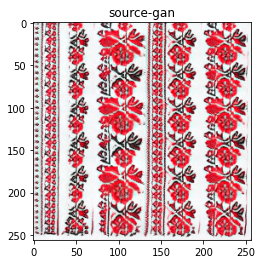

In [17]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

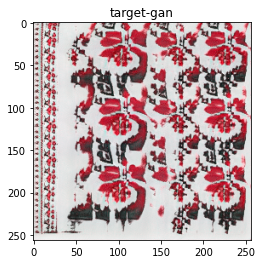

In [18]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

# Build Video

The following code builds a transition video between the two latent vectors previously obtained.

In [22]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

!pip install imageio-ffmpeg
lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = NETWORK
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
   
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 56.3 MB/s eta 0:00:00


  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


# Download Video

In [23]:
from google.colab import files
files.download("movie.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>